In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from osgeo import gdal
from PIL import Image

In [24]:
#RED
ds_red = gdal.Open('img/3. IMG_700101_000458_0092_RED.TIF')
image_red = ds_red.ReadAsArray()

#NIR
ds_nir = gdal.Open('img/2. IMG_700101_000458_0092_NIR.TIF')
image_nir=ds_nir.ReadAsArray()

#REG
ds_reg = gdal.Open('img/4. IMG_700101_000458_0092_REG.TIF')
image_reg=ds_reg.ReadAsArray()

#GRE
ds_gre = gdal.Open('img/1. IMG_700101_000458_0092_GRE.TIF')
image_gre = ds_gre.ReadAsArray()

In [25]:
# create NDVI index
ndvi = (image_nir - image_red) / (image_nir + image_red+0.0001)

In [26]:
# flatten NDVI and GRE images into 1D arrays
ndvi_flat = ndvi.flatten()
gre_flat = image_gre.flatten()


In [27]:
# create 2D array with NDVI and GRE values
data = np.column_stack((ndvi_flat, gre_flat))

# calculate mean and covariance matrix
mean = np.mean(data, axis=0)
cov = np.cov(data.T)

In [28]:
# create grid of points
x, y = np.mgrid[-1:1:.01, 0:1:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y

In [29]:
# create multivariate normal distribution
rv = multivariate_normal(mean=mean, cov=cov)


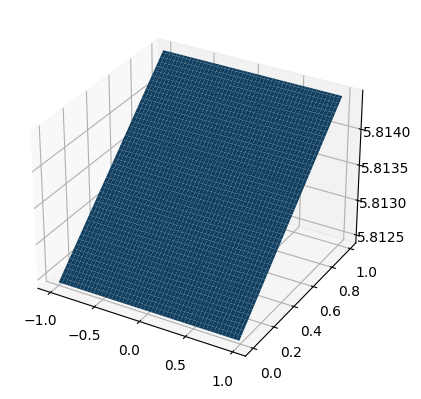

In [30]:
# calculate probability density function at each point in grid
z = rv.pdf(pos)

# plot 3D Gaussian bell
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z)
plt.show()

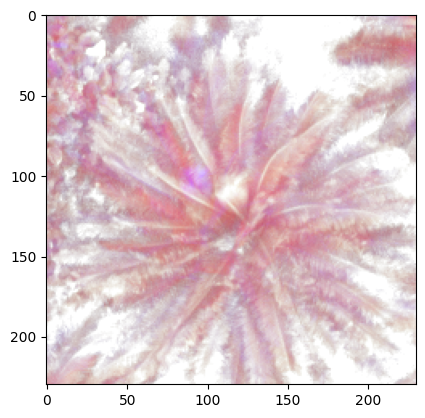

In [31]:
image = np.load('./img/multispectral.npy')

# Visualize the image using matplotlib
plt.imshow(image)
plt.show()

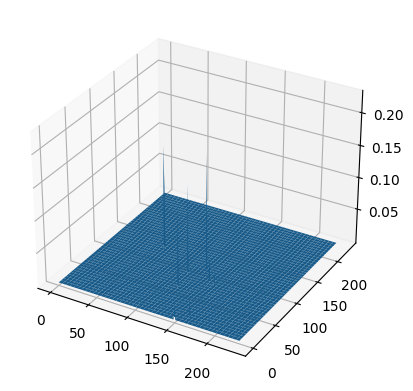

In [32]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define function to calculate NDVI from input red and near-infrared bands
def ndvi(red, nir):
    ndvi = (nir - red) / (nir + red+0.00001)
    return ndvi

# Load input images
red = np.array(Image.open('./img/cropped/red.tif'))
nir = np.array(Image.open('./img/cropped/nir.tif'))
gre = np.array(Image.open('./img/cropped/gre.tif'))
reg = np.array(Image.open('./img/cropped/reg.tif'))

# Crop images to the same dimensions
min_shape = np.min([red.shape, nir.shape, gre.shape, reg.shape], axis=0)
red = red[:min_shape[0], :min_shape[1]]
nir = nir[:min_shape[0], :min_shape[1]]
gre = gre[:min_shape[0], :min_shape[1]]
reg = reg[:min_shape[0], :min_shape[1]]

# Calculate NDVI
ndvi_img = ndvi(red, nir)

# Create 3D Gaussian function
def gaussian_3d(x, y, z, x0, y0, z0, sigma_x, sigma_y, sigma_z):
    return np.exp(-((x-x0)**2/(2*sigma_x**2) + (y-y0)**2/(2*sigma_y**2) + (z-z0)**2/(2*sigma_z**2)))

# Create grid for plotting
x = np.linspace(0, ndvi_img.shape[1], ndvi_img.shape[1])
y = np.linspace(0, ndvi_img.shape[0], ndvi_img.shape[0])
X, Y = np.meshgrid(x, y)

# Set Gaussian parameters
x0 = ndvi_img.shape[1] / 2
y0 = ndvi_img.shape[0] / 2
z0 = ndvi_img.max()
sigma_x = ndvi_img.shape[1] / 4
sigma_y = ndvi_img.shape[0] / 4
sigma_z = ndvi_img.max() / 4

# Evaluate Gaussian function on grid
Z = gaussian_3d(X, Y, ndvi_img, x0, y0, z0, sigma_x, sigma_y, sigma_z)

# Plot 3D Gaussian
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
plt.show()
